# Prepping the Data
First we import the csv files for both the training and testing datasets. From there we drop the columns that we don't need ile id and attack_cat (attack category).  

Next, we prime our test data into X, dropping the label column which we will use for our y values to check our accuracy.

For the proto, service and state columns, since those are categorical but in text format, we update those and change them into integers representing their categories.

We now need to seperate our numerical vs. categorical features for use in the scaler later on, so we create a couple of vectors for those called num_features and cat_features.

We do this process on both the training data as well as the testing data to have both primed for our model training and testing.

In [1]:
import pandas as pd

train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')

train.drop(['id', 'attack_cat'], axis = 1, inplace= True)
test.drop(['id', 'attack_cat'], axis = 1, inplace= True)

X = train.drop('label', axis = 1)
y = train['label']
X.proto = pd.Categorical(pd.factorize(X.proto)[0] + 1)
X.service = pd.Categorical(pd.factorize(X.service)[0] + 1)
X.state = pd.Categorical(pd.factorize(X.state)[0] + 1)

num_features = X.select_dtypes(exclude=['category']).columns.values

cat_features = X.select_dtypes(include=['category']).columns.values


X_t = test.drop('label', axis = 1)
y_t = test['label']

X_t.proto = pd.Categorical(pd.factorize(X_t.proto)[0] + 1)
X_t.service = pd.Categorical(pd.factorize(X_t.service)[0] + 1)
X_t.state = pd.Categorical(pd.factorize(X_t.state)[0] + 1)

test_num_features = X_t.select_dtypes(exclude=['category']).columns.values

test_cat_features = X_t.select_dtypes(include=['category']).columns.values

# Trying Out Different Models

Now that we have the data sets primed, it's time to do a little pre-processing and train some models to see how well they perform.

We assign our numeric and categorical vectors to a couple of pre-processing procedures. The numerical to an imputer to handle missing data, which this set really doesn't have, but better safe than sorry, and then a scaler to bring all of the numeric data to the same scale. For the categorical, we already relabeled them from text to integer, so now we just run them through a OneHotEncoder which will blow them up into binary vectors based on the label. We can now throw these pre-processing procedures into a preprocessing pipeline for use in our model pipleine.

Now we set up a new model pipeline for each type of model we want to test out. The first is a logistic regression model with the max_iter set to 2000 maximum iterations because the default of 100 wasn't enough (neither was 1000) for convergence. The second is an SVM model using the LinearSVC engine for classification, and this one wouldn't converge even with the max_iter set to 10,000, and the higher iterations didn't seem to make much of a difference for accuracy, so for speed's sake we kept the default of 1000. Next is the decision tree classifier, which we did some experimentation later on to find an optimal ccp_alpha to use for max accuracy (discussed further down). Finally, we tried out the SGDClassifier (stochastic gradient descent), again with defaults set for comparison.

The results of the runs on both the training and testing sets are below:

> Logistic Regression model train score: **0.935**  
> Logistic Regression model test score: **0.798**  
> SVC model train score: **0.935**  
> SVC model test score: **0.558**  
> Decision Tree model train score: **0.951**  
> Decision Tree model test score: **0.844**  
> Stochastic Gradient Descent model train score: **0.934**  
> Stochastic Gradient Descent model test score: **0.773**  

It seems that the decision tree model is the most performant model out of the models we picked, so we decided to go with that model and see if we could tweak it any to improve the prediction accuracy.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier

numeric_features = num_features
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = cat_features
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

lr_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter = 2000))] #incresed max_iter, default 100 wasn't enough
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr_pl.fit(X_train, y_train)
print("Logistic Regression model score: %.3f" % lr_pl.score(X_test, y_test))
print("Logistic Regression model test score: %.3f" % lr_pl.score(X_t, y_t))

svc_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LinearSVC(max_iter = 1000))] #increased max_iter, default 1000 wasn't enough, neither was 2000, nor 4000, nor 10000, and that's as far as I'm going
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

svc_pl.fit(X_train, y_train)
print("SVC model score: %.3f" % svc_pl.score(X_test, y_test))
print("SVC model test score: %.3f" % svc_pl.score(X_t, y_t))

dtc_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DTC(random_state = 0))] #accuracy on test data drops dramatically at .0007, .0003 gives .832, 0004 gives .862
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

dtc_pl.fit(X_train, y_train)
print("Decision Tree model score: %.3f" % dtc_pl.score(X_test, y_test))
print("Decision Tree model test score: %.3f" % dtc_pl.score(X_t, y_t))

sgd_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SGDClassifier())] 
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sgd_pl.fit(X_train, y_train)
print("Stochastic Gradient Descent model score: %.3f" % sgd_pl.score(X_test, y_test))
print("Stochastic Gradient Descent model test score: %.3f" % sgd_pl.score(X_t, y_t))

Logistic Regression model score: 0.935
Logistic Regression model test score: 0.798


C:\Users\aller\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVC model score: 0.935
SVC model test score: 0.558
Decision Tree model score: 0.951
Decision Tree model test score: 0.844
Stochastic Gradient Descent model score: 0.933
Stochastic Gradient Descent model test score: 0.775


# Base Decision Tree Confusion Matrix

But before we did any tweaking, we wanted to see what the default confusion matrix was without any modifiers to the decision tree parameters. The model is pretty good at picking up both true positives and true negatives, which is expected with an accuracy of 84%. 

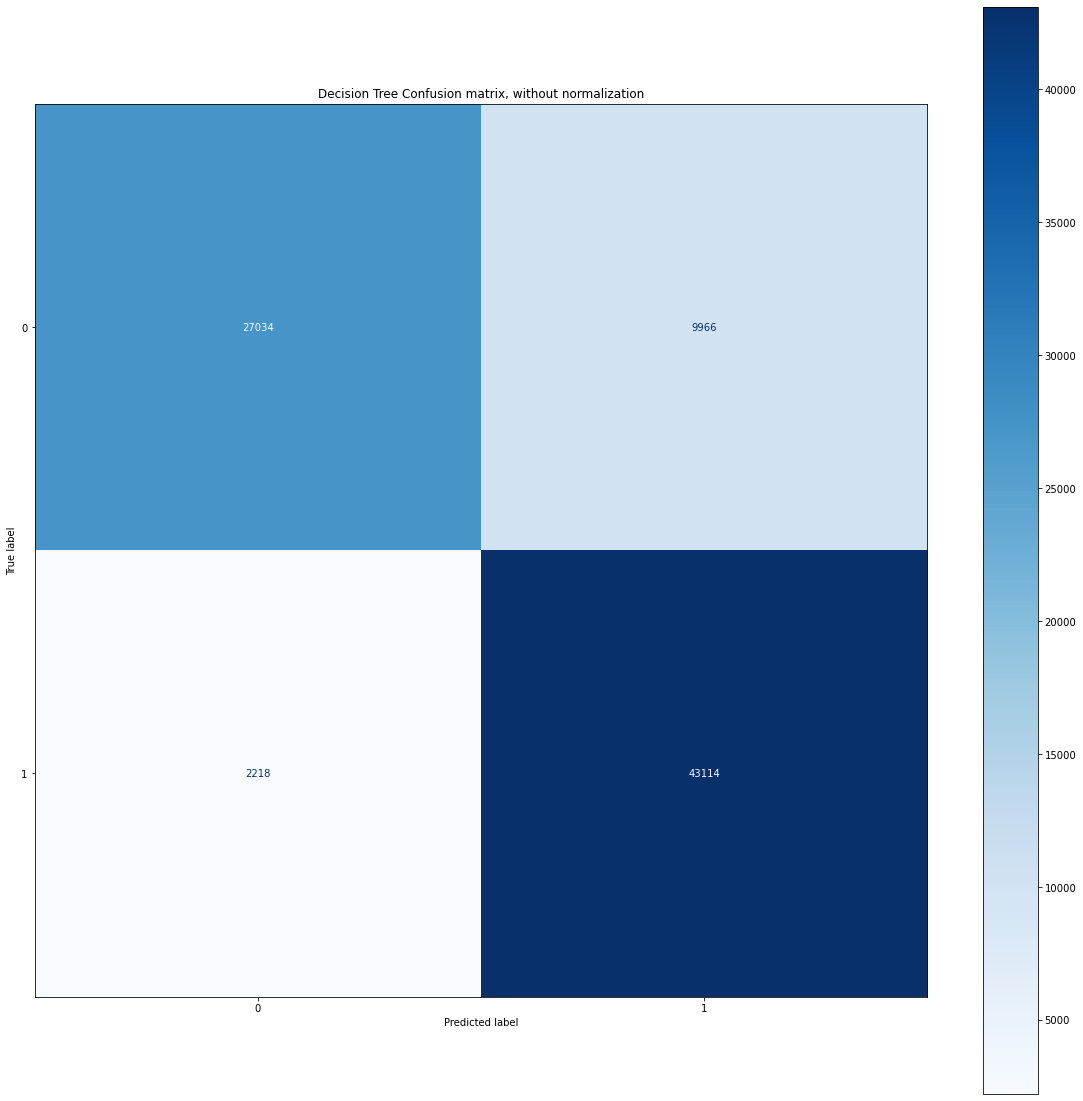

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

prediction = dtc_pl.predict(X_t)
fig, ax = plt.subplots(figsize=(20, 20))

disp = ConfusionMatrixDisplay.from_predictions(y_t, prediction, cmap=plt.cm.Blues, display_labels=dtc_pl.classes_, ax = ax)
disp.ax_.set_title('Decision Tree Confusion matrix, without normalization')
plt.show()

Now we wanted to see if we could find an optimal ccp_alpha to use in the decision tree to boost the accuracy beyond the default settings. Below we set up the test, including setting the pruning paths to prevent possible overfitting.

In [31]:
clf = DTC(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

The graph below shows the effective alphas against the leaf impurities in the tree. Just from this graph it seems that the model is fairly efficient as-is, but we pressed ahead.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

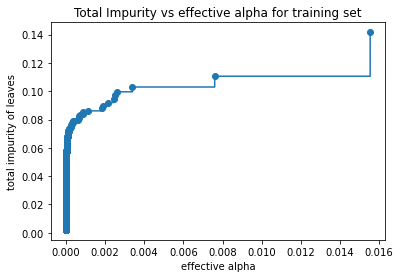

In [32]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

We can calculate the alpha that would prune the entire tree here, so this is the node we can remove because it doesn't do anything for us.

In [34]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DTC(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.29284304086104024


Here we can see the number of nodes in the tree, as well as the depth of the tree, decreases as alpha increases. There is a pretty sharp curve at the very bottom indicating that even the default model is generalizing pretty well, so we won't have a very large alpha at all.

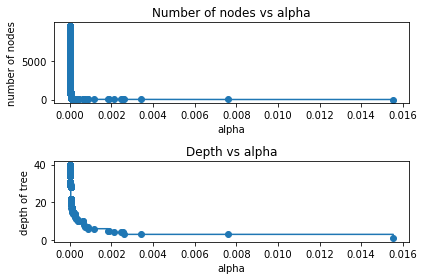

In [35]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Here is where we get into the meat of the analysis. We are going to iterate over all of the alphas identified above and train the model with those and see how they compare. As expected, it seems the model generalizes pretty well, with the accuracy starting to lose stability and a sharp accuracy dropoff around an alpha of .00073777. We made an alpha adjustment further down to get max accuracy for this testing set, but it doesn't improve the accuracy very much at all over the default 0 alpha, again, showing the model generalized pretty well, so we don't think it's actually needed in this situation. 

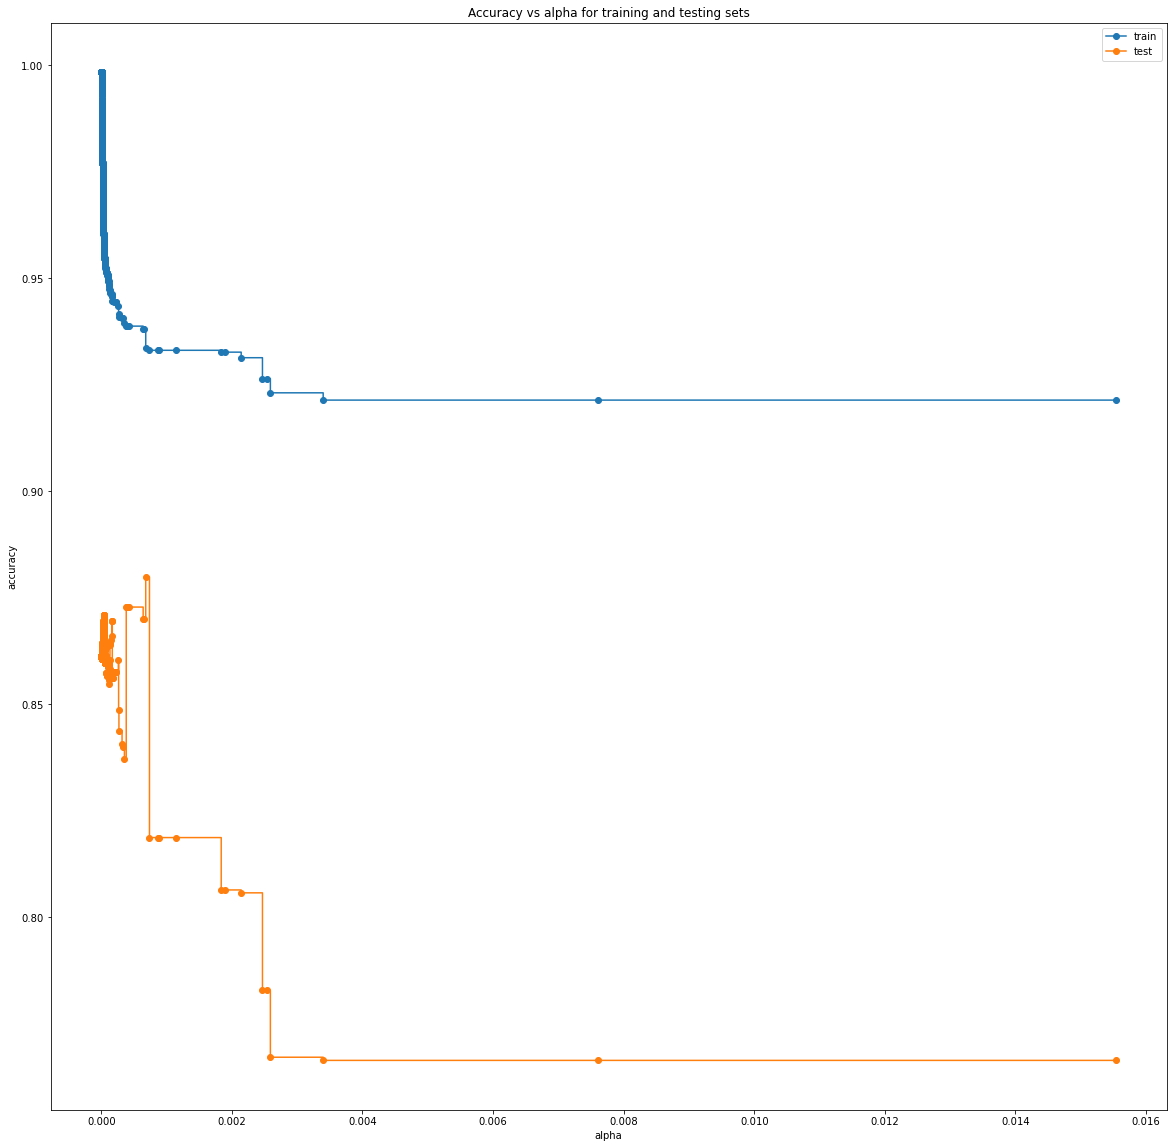

[0.00012649 0.00012762 0.00013273 0.00013912 0.00015241 0.0001565
 0.00015909 0.00015912 0.00016661 0.00016833 0.00017546 0.00018066
 0.00018983 0.00022631 0.0002301  0.00026272 0.00026518 0.00027001
 0.0003178  0.00032757 0.00035391 0.00038179 0.00039244 0.00042491
 0.00064082 0.00065119 0.00068052 0.00073777 0.00086808 0.00088909
 0.0011457  0.00183632 0.00189505 0.00214216 0.00246803 0.00253052
 0.00258925 0.00339791 0.00760131 0.01553689]
[0.8582568138755283, 0.8603580624787446, 0.8642569110430938, 0.8637953651071273, 0.8649006461643104, 0.8660059272214935, 0.8695039595782927, 0.8695039595782927, 0.8695039595782927, 0.8561677112179954, 0.8561677112179954, 0.8561677112179954, 0.8575159111888452, 0.8575159111888452, 0.8575159111888452, 0.860224457076228, 0.8486615167856969, 0.8437302628382646, 0.8404751493951319, 0.840001457513482, 0.8369892629840159, 0.8727347811300588, 0.8727347811300588, 0.8727347811300588, 0.8700019433513093, 0.8700019433513093, 0.879791575572074, 0.8186245931108

In [53]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_t, y_t) for clf in clfs]

fig, ax = plt.subplots(figsize = (20,20))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.tick_params(axis = 'both', which = 'both')
ax.legend()
plt.show()

Here we are showing an alpha hat boosts the accuracy by close to 2%. A decent gain, but not mind blowing considering the amount of cpu work went into finding that 2% gain. Again, the model itself generalizes well, for models that seem to overfit with the default values, this exercise would be much more important.

In [7]:
dtc_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DTC(random_state = 0, ccp_alpha = .00039244))]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

dtc_pl.fit(X_train, y_train)
print("Decision Tree model score: %.3f" % dtc_pl.score(X_test, y_test))
print("Decision Tree model test score: %.3f" % dtc_pl.score(X_t, y_t))

Decision Tree model score: 0.938
Decision Tree model test score: 0.862


# Feature Selection

We did experiment with feature selection to see if we could boost the model accuracy any by paring down the features used in the model. We ran several difference correlation matrixes to find possible candidates and ran those matchings manually, and we also used the SelectKBest feature selection method from Sci-Kit Learn to have it chose the k best fitting features to see what the accuracy would be. We didn't find large gains for the most part, and many times the model performed worse. With only 42 features, and since this isn't running in real-time, feature selection didn't seem to be worth the effort. However, if this were to be implemented in a real-time process, sacrificing a few percentage points in accuracy for speed with a reduced feature set would be worth the effort.



In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

ks = []
train_scores = []
test_scores = []

for i in range(1, 42):
    X_new = SelectKBest(chi2, k=i).fit(X, y)
    names = X_new.get_support(1)
    X_new = X[X.columns[names]]
    num_features =X_new.select_dtypes(exclude=['category']).columns.values
    cat_features = X_new.select_dtypes(include=['category']).columns.values
    
    numeric_features = num_features
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )

    categorical_features = cat_features
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", DTC())] 
    )

    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

    clf.fit(X_train, y_train)
    ks.append(i)
    train_scores.append(clf.score(X_test, y_test))
    test_scores.append(clf.score(X_t, y_t))

array([20], dtype=int64)

array([20, 21], dtype=int64)

array([11, 20, 21], dtype=int64)

array([11, 12, 20, 21], dtype=int64)

array([ 8, 11, 12, 20, 21], dtype=int64)

array([ 7,  8, 11, 12, 20, 21], dtype=int64)

array([ 7,  8, 11, 12, 15, 20, 21], dtype=int64)

array([ 6,  7,  8, 11, 12, 15, 20, 21], dtype=int64)

array([ 6,  7,  8, 11, 12, 15, 20, 21, 29], dtype=int64)

array([ 6,  7,  8, 11, 12, 15, 18, 20, 21, 29], dtype=int64)

array([ 6,  7,  8, 11, 12, 15, 18, 20, 21, 27, 29], dtype=int64)

array([ 6,  7,  8,  9, 11, 12, 15, 18, 20, 21, 27, 29], dtype=int64)

array([ 6,  7,  8,  9, 11, 12, 15, 17, 18, 20, 21, 27, 29], dtype=int64)

array([ 6,  7,  8,  9, 11, 12, 15, 17, 18, 19, 20, 21, 27, 29],
      dtype=int64)

array([ 6,  7,  8,  9, 11, 12, 15, 17, 18, 19, 20, 21, 22, 27, 29],
      dtype=int64)

array([ 5,  6,  7,  8,  9, 11, 12, 15, 17, 18, 19, 20, 21, 22, 27, 29],
      dtype=int64)

array([ 5,  6,  7,  8,  9, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 27, 29],
      dtype=int64)

array([ 5,  6,  7,  8,  9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27,
       29], dtype=int64)

array([ 1,  5,  6,  7,  8,  9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       27, 29], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 27, 29], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 27, 29], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 27, 29, 35], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 27, 29, 33, 35], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 27, 29, 33, 34, 35], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 27, 29, 33, 34, 35, 40], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 27, 29, 30, 33, 34, 35, 40], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 27, 29, 30, 33, 34, 35, 39, 40], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 27, 29, 30, 32, 33, 34, 35, 39, 40], dtype=int64)

array([ 1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40], dtype=int64)

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40], dtype=int64)

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40],
      dtype=int64)

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 26, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40],
      dtype=int64)

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 26, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41],
      dtype=int64)

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41],
      dtype=int64)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 32, 33, 34, 35, 39, 40,
       41], dtype=int64)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 32, 33, 34, 35, 38, 39,
       40, 41], dtype=int64)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 38,
       39, 40, 41], dtype=int64)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       38, 39, 40, 41], dtype=int64)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 38, 39, 40, 41], dtype=int64)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 38, 39, 40, 41], dtype=int64)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 37, 38, 39, 40, 41], dtype=int64)

From the plot below, it looks like k = 8 features is the sweet spot for this test set, but again, it's not a huge improvement over the full feature set. So unless this were to be implemented in a real-time system where speed is a major factor, the full feature set should be fine to use for the model.

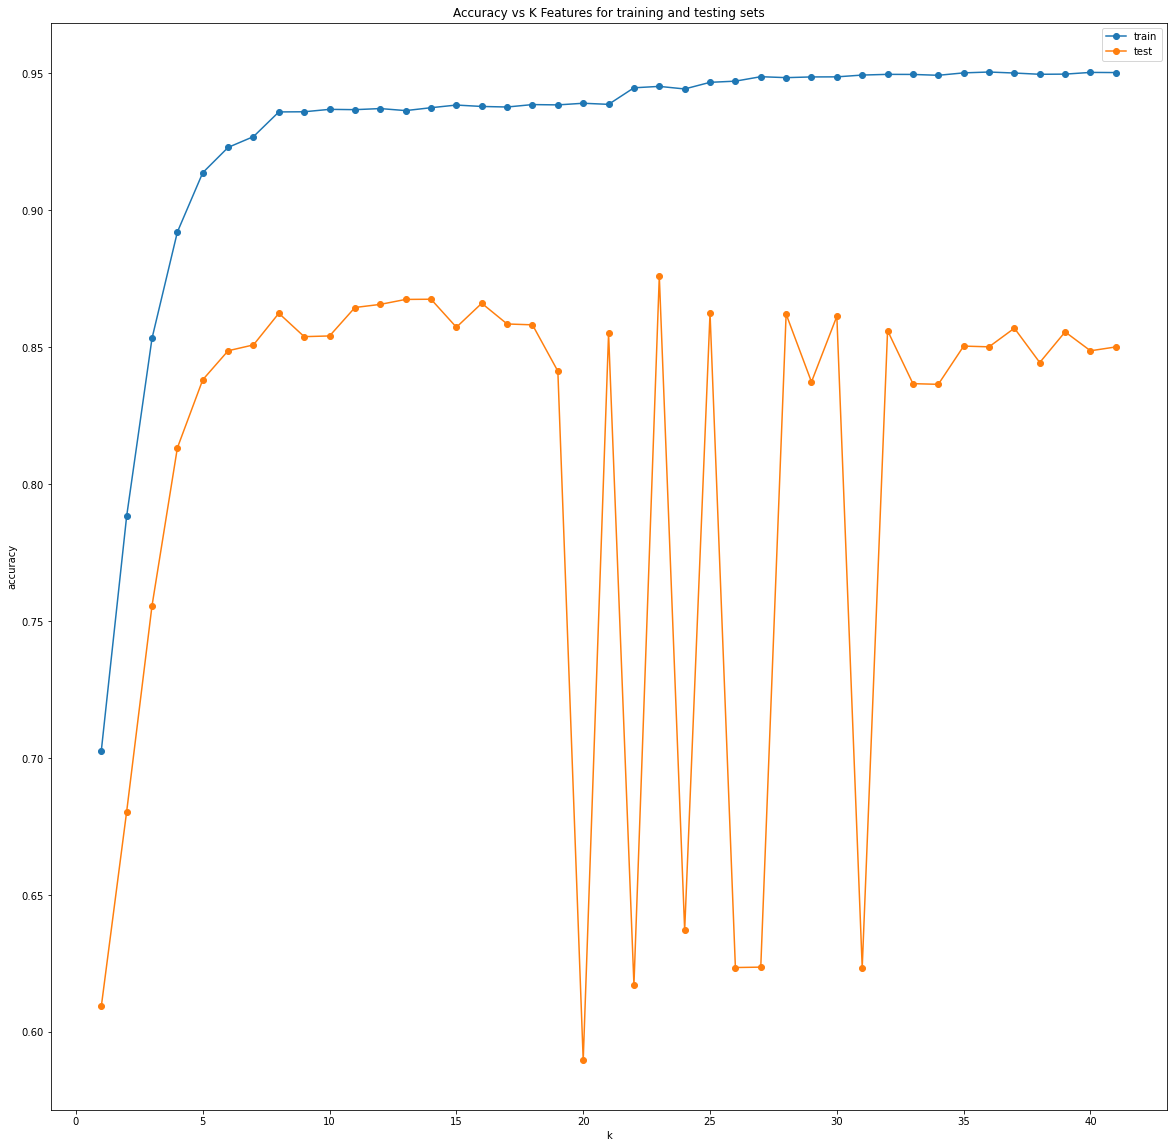

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (20,20))
ax.set_xlabel("k")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs K Features for training and testing sets")
ax.plot(ks, train_scores, marker="o", label="train")
ax.plot(ks, test_scores, marker="o", label="test")
ax.tick_params(axis = 'both', which = 'both')
ax.legend()
plt.show()

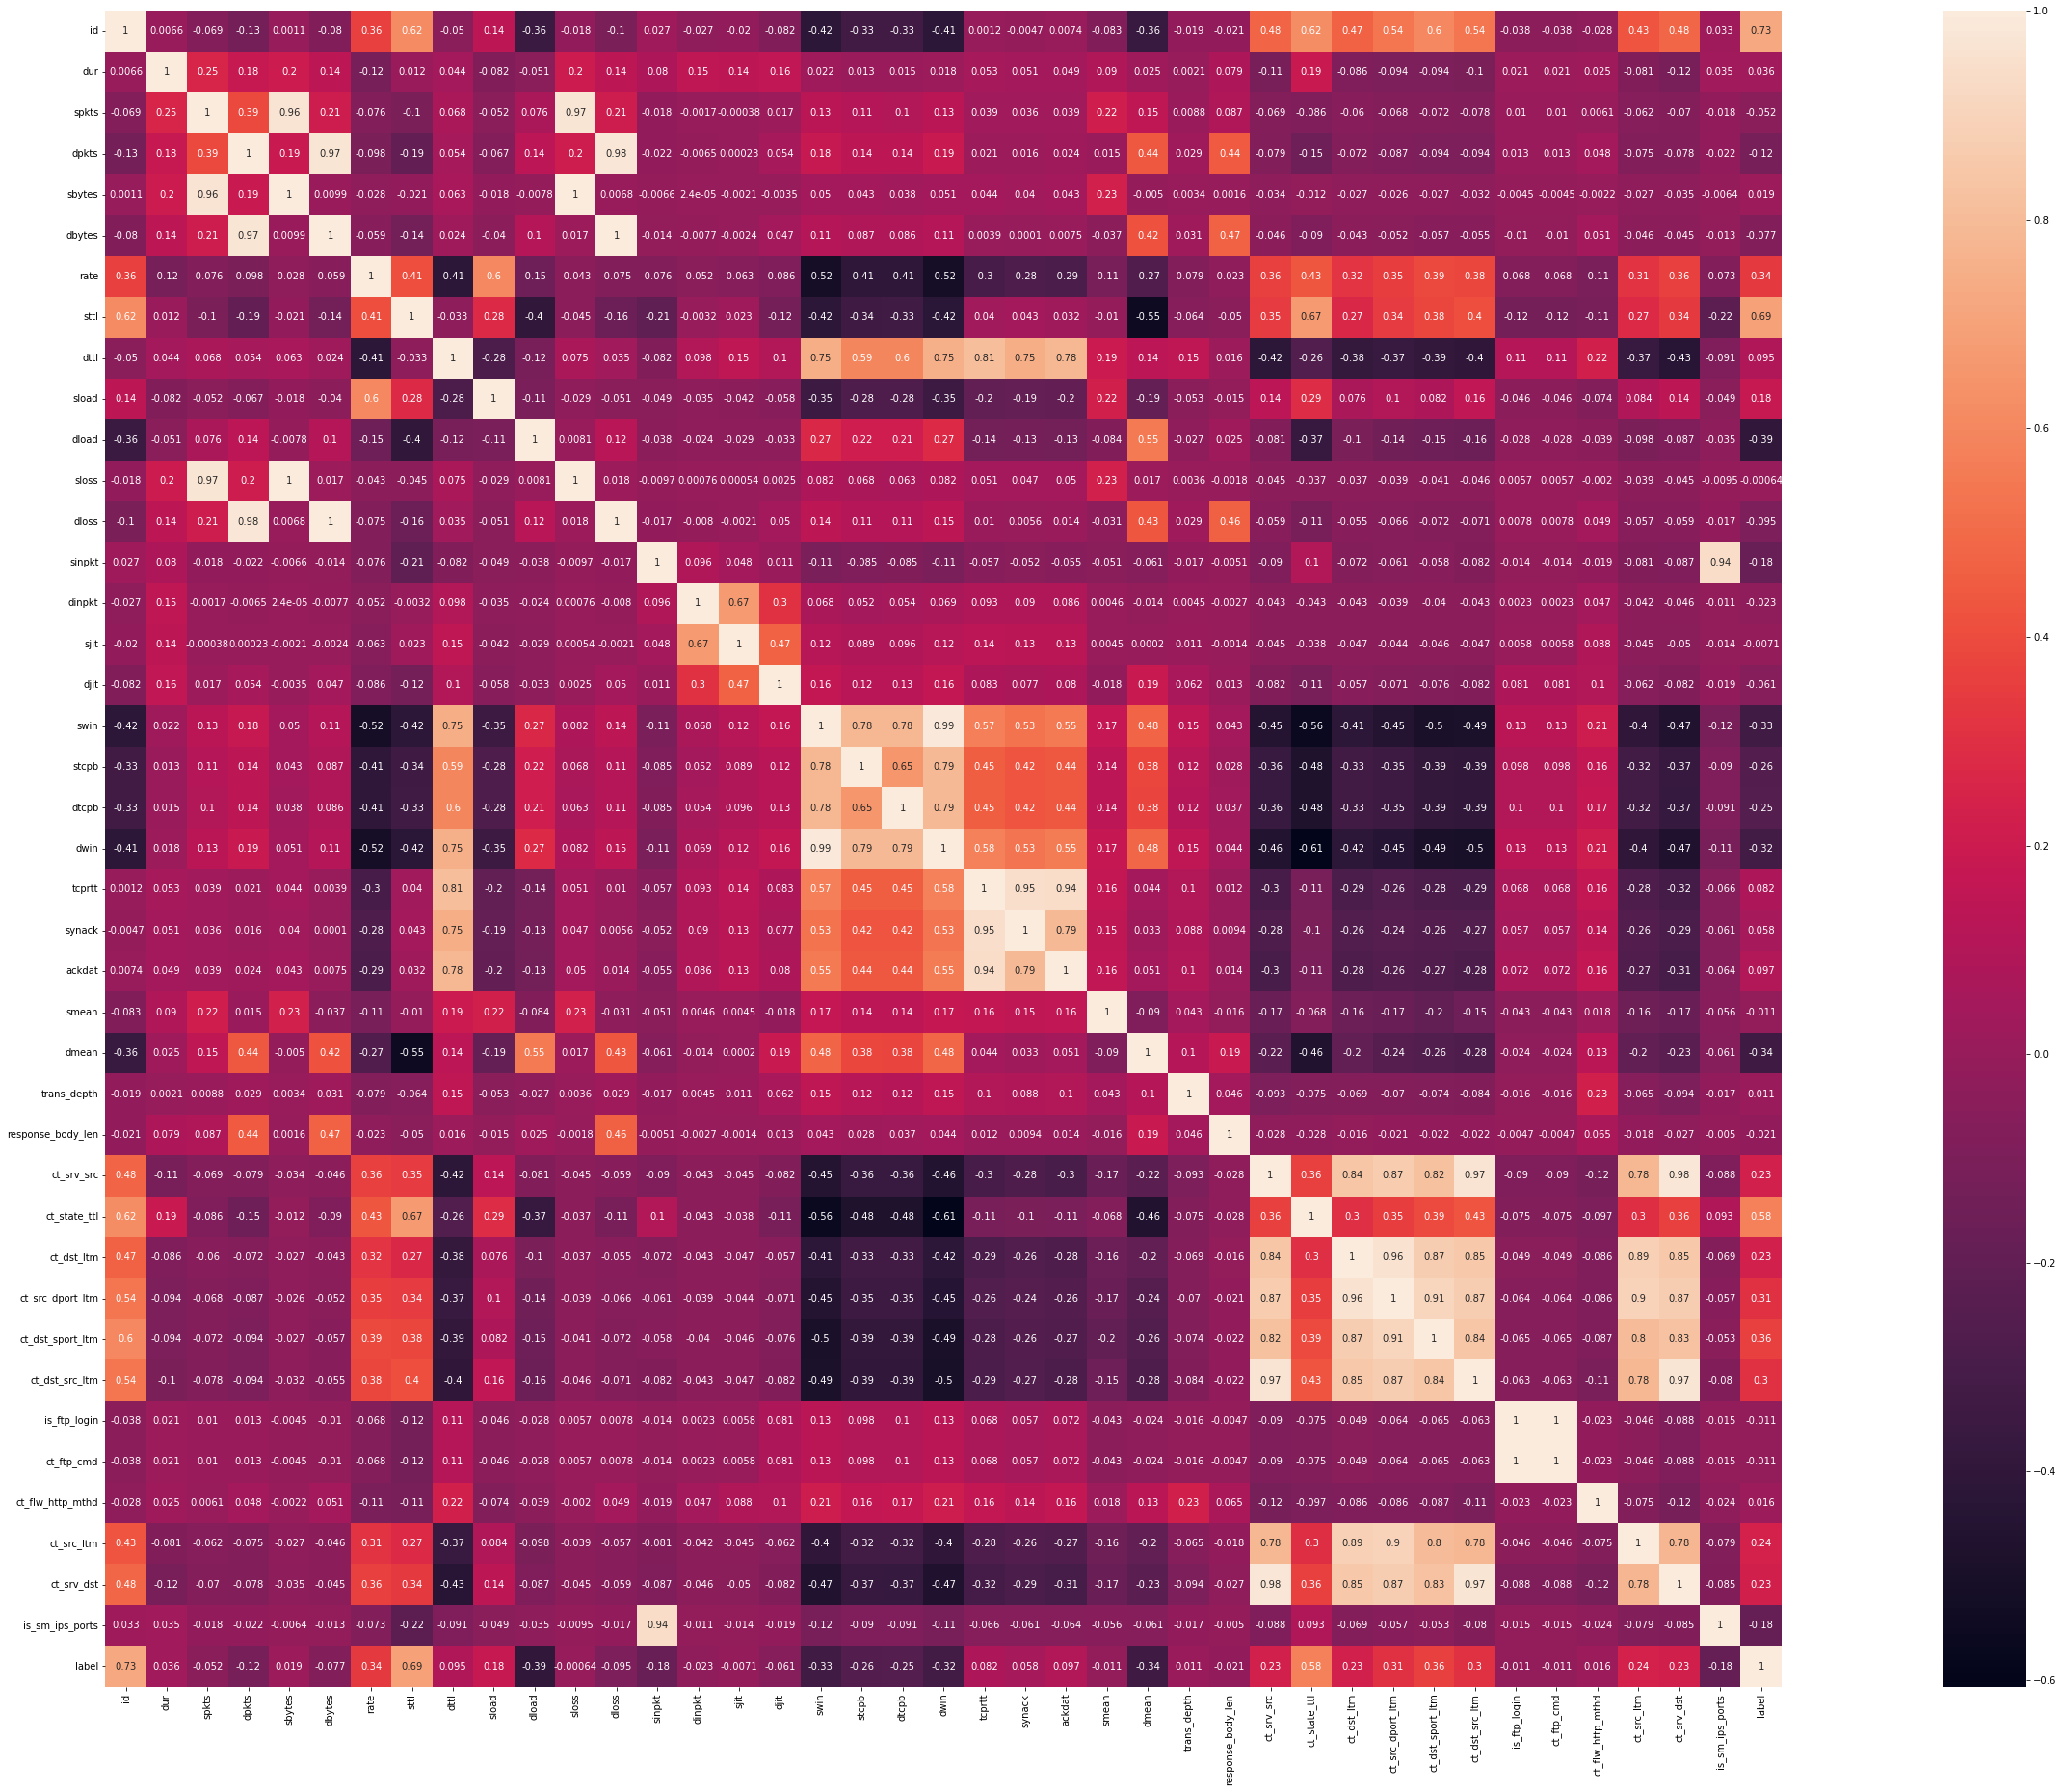

In [13]:
corrmat = train.corr()
plt.figure(figsize=(60,32))
sns.heatmap(corrmat, annot = True, square = True);